In [1]:
#2. How much losses every month can we project in 2011 if same trend of absenteeism continues?


In [2]:
##Import Libararies

import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression,Lars
from sklearn.ensemble import  RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
##Import Data
data = pd.read_excel('Absenteeism_at_work_Project.xls')
data_org = data
col = data.columns
# Numerical and Categorical Variables
n_col = ['Transportation expense', 'Distance from Residence to Work','Service time', 
         'Age', 'Work load Average/day ', 'Hit target','Son','Pet', 'Weight', 'Height', 
         'Body mass index','Absenteeism time in hours']
c_col = ['ID', 'Reason for absence', 'Month of absence', 'Day of the week','Seasons', 'Disciplinary failure', 
         'Education','Social drinker','Social smoker',]

In [4]:
# Identify Columnwise Missing Values 
missing_val = pd.DataFrame(data.isnull().sum())
missing_val.reset_index()
missing_val = missing_val.rename(columns = {'index' : 'variables', 0:'miss_value'})
row,col = data.shape
missing_val['miss_percentage'] = round((missing_val['miss_value']/row)*100,2)
missing_val = missing_val.sort_values('miss_percentage',ascending=False)
# Select sample data and find best method to predict missing values
#missing_val
# impute BMI
temp = data[['Weight', 'Height', 'Body mass index']]
temp['pred_BMI'] = (data['Weight']/(data['Height']**2))*10000
temp['error_BMI'] = temp['Body mass index']-temp['pred_BMI']
#print(temp['error_BMI'].dropna().mean())
data['Body mass index'].fillna((data['Weight']/(data['Height']**2))*10000,inplace = True)
# impute Height
temp['pred_Height'] = ((data['Weight']/data['Body mass index'])*10000)**0.5
temp['error_Height'] = temp['Height']-temp['pred_Height']
#print(temp['error_Height'].dropna().mean())
data['Height'].fillna(((data['Weight']/data['Body mass index'])*10000)**0.5,inplace = True)
# impute Weight
temp['pred_Weight'] = ((data['Height']**2)*data['Body mass index'])/10000
temp['error_Weight'] = temp['Weight']-temp['pred_Weight']
#print(temp['error_Weight'].dropna().mean())
data['Weight'].fillna(((data['Height']**2)*data['Body mass index'])/10000,inplace = True)
# Selecting best method to impute missing value
# Crete dummy missing value
temp_data = data
temp_data['Body mass index'].iloc[22] # 27.0
temp_data['Body mass index'].iloc[22] = np.NaN
#temp_data['Body mass index'].iloc[22]
temp_data['Body mass index'].mean() #26.68
temp_data['Body mass index'].iloc[22] = np.NaN
temp_data['Body mass index'].median() #25
temp_data['Body mass index'].iloc[22] = np.NaN
temp_data = pd.DataFrame(KNN(k=3).complete(temp_data),columns = temp_data.columns)
temp_data['Body mass index'].iloc[22] # 27
# Best match by KNN
data = temp_data
# Check any Columnwise Missing Values 
#pd.DataFrame(data.isnull().sum())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

Imputing row 1/740 with 0 missing, elapsed time: 0.169
Imputing row 101/740 with 0 missing, elapsed time: 0.172
Imputing row 201/740 with 0 missing, elapsed time: 0.173
Imputing row 301/740 with 0 missing, elapsed time: 0.174
Imputing row 401/740 with 0 missing, elapsed time: 0.175
Imputing row 501/740 with 0 missing, elapsed time: 0.176
Imputing row 601/740 with 0 missing, elapsed time: 0.177
Imputing row 701/740 with 0 missing, elapsed time: 0.177


In [5]:
# Impute outliers 
df = data
for col in n_col:
    percentiles = df[col].quantile([0.01,0.99]).values
    df[col][df[col] <= percentiles[0]] = percentiles[0]
    df[col][df[col] >= percentiles[1]] = percentiles[1]
data = df
#data.shape

In [6]:
df1 = data.applymap(int)
for i in c_col[1:]:
    df1[i].astype('str')
temp = pd.DataFrame(df1['Absenteeism time in hours'])
temp = temp.join(data[n_col[0:-1]])
for i in c_col[1:]:
    d = pd.get_dummies(df1[i],prefix = i)
    temp = temp.join(d)
data_hotencod = temp
data_hotencod.shape

(740, 74)

In [7]:
# Hot Encoded/dummy Varibles Data
# Feature Importance Matrix Random Forest for 
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=300).fit(data_hotencod.iloc[:,1:],data_hotencod.iloc[:,0])
importances = list(rf_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(data_hotencod.columns),
                                                                                      importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:32} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Absenteeism time in hours        Importance: 0.08
Variable: Age                              Importance: 0.08
Variable: Service time                     Importance: 0.07
Variable: Reason for absence_18            Importance: 0.07
Variable: Work load Average/day            Importance: 0.05
Variable: Reason for absence_12            Importance: 0.05
Variable: Transportation expense           Importance: 0.04
Variable: Reason for absence_8             Importance: 0.04
Variable: Month of absence_11              Importance: 0.04
Variable: Day of the week_2                Importance: 0.04
Variable: Weight                           Importance: 0.03
Variable: Reason for absence_11            Importance: 0.03
Variable: Distance from Residence to Work  Importance: 0.02
Variable: Hit target                       Importance: 0.02
Variable: Son                              Importance: 0.02
Variable: Pet                              Importance: 0.02
Variable: Reason for absence_9          

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
feature_importances

[('Absenteeism time in hours', 0.08),
 ('Age', 0.08),
 ('Service time', 0.07),
 ('Reason for absence_18', 0.07),
 ('Work load Average/day ', 0.05),
 ('Reason for absence_12', 0.05),
 ('Transportation expense', 0.04),
 ('Reason for absence_8', 0.04),
 ('Month of absence_11', 0.04),
 ('Day of the week_2', 0.04),
 ('Weight', 0.03),
 ('Reason for absence_11', 0.03),
 ('Distance from Residence to Work', 0.02),
 ('Hit target', 0.02),
 ('Son', 0.02),
 ('Pet', 0.02),
 ('Reason for absence_9', 0.02),
 ('Month of absence_3', 0.02),
 ('Month of absence_6', 0.02),
 ('Month of absence_12', 0.02),
 ('Seasons_3', 0.02),
 ('Height', 0.01),
 ('Reason for absence_0', 0.01),
 ('Reason for absence_5', 0.01),
 ('Reason for absence_6', 0.01),
 ('Reason for absence_10', 0.01),
 ('Reason for absence_13', 0.01),
 ('Reason for absence_17', 0.01),
 ('Reason for absence_24', 0.01),
 ('Month of absence_2', 0.01),
 ('Month of absence_5', 0.01),
 ('Month of absence_10', 0.01),
 ('Day of the week_3', 0.01),
 ('Day of

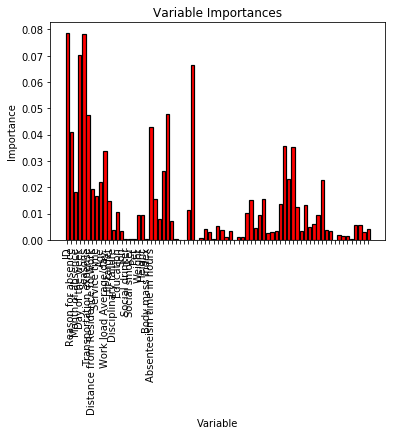

In [9]:
# Importance plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, data.columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Number of features for 90% importance: 31


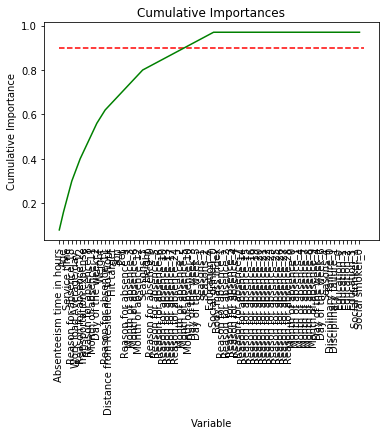

In [10]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 90% of importance retained
plt.hlines(y = 0.90, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
# Find number of features for cumulative importance of 90%
# Add 1 because Python is zero-indexed
print('Number of features for 90% importance:', np.where(cumulative_importances > 0.90)[0][0] + 1)

In [11]:
#selecting top 15 features
new = SelectKBest(f_regression,k=33).fit_transform(data_hotencod.iloc[:,1:],data_hotencod.iloc[:,0])
X_train, X_test, y_train, y_test = train_test_split(new,data_hotencod.iloc[:,0], test_size=0.2,random_state=42)

In [12]:
#Decision Tree
dt_model=DecisionTreeRegressor(random_state=3).fit(X_train,y_train)
pred = dt_model.predict(X_test) 
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred)))
#print('Model Score :', rf_model.score(X_test, y_test))

RMSE :  14.63159324957542


In [13]:
#Random forest
rf_model = RandomForestRegressor(n_estimators=700).fit(X_train,y_train)
pred = rf_model.predict(X_test) 
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred))),
print('Model Score :', rf_model.score(X_test, y_test))

RMSE :  10.948537317768395
Model Score : -0.10319502095818556


In [14]:
#Linear Regression
import statsmodels.api as sm
lr_model = sm.OLS(y_train,X_train).fit()
pred = lr_model.predict(X_test)
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred)))
#print('Model Score :', lr_model.score(X_test, y_test))#lr_model.summary()

RMSE :  10.207906537284423


In [15]:
#Ridge Regression
ridge_model=Ridge().fit(X_train,y_train)
pred = ridge_model.predict(X_test)
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred)))
print('Model Score :', ridge_model.score(X_test, y_test))

RMSE :  10.057751311192343
Model Score : 0.06901673759697602


In [16]:
#Lasso regression
lasso_model=Lasso().fit(X_train,y_train)
pred = lasso_model.predict(X_test)
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred)))
print('Model Score :', lasso_model.score(X_test, y_test))

RMSE :  10.285971894071205
Model Score : 0.02628748114445323


In [17]:
#Lars Regression
lars_model=Lars().fit(X_train,y_train)
pred = lars_model.predict(X_test)
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred))),print('Model Score :', lars_model.score(X_test, y_test))

RMSE :  10.180298714992146
Model Score : 0.04619162822504064


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.410e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.205e-03, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.553e-03, with an active set of 29 regressors, and the smallest cholesky pivot eleme

(None, None)

In [18]:
#data_hotencod.columns

In [19]:
#data=data_hotencod.drop(['ID'],axis=1)
#pca = PCA(n_components=73)
#pca.fit(data_hotencod.values)
#The amount of variance that each PC explained
#var= pca.explained_variance_ratio_
#Cumulative Variance
#var1=np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)
#graph of the variance
#plt.plot(var1)

In [20]:
#############################
## from the above plot
#The plot above shows that ~ 40 components explains around 99% variance in the data set.
#By using PCA we have reduced 72 predictors to 40 without compromising on explained variance.
#############################
#Looking at above plot I'm taking 40 variables
pca = PCA(n_components=37)
#now fitting the selected components to the data
pca.fit(data_hotencod.values)
#PCA selected features
X1=pca.fit_transform(data_hotencod.values)
#splitting train and test data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X1,data_hotencod['Absenteeism time in hours'],
                                                                    test_size=0.2,random_state=42)

In [21]:
# PCA_Decision Tree
dt_model=DecisionTreeRegressor(random_state=3).fit(X_train_pca,y_train_pca)
pred = dt_model.predict(X_test_pca) 
print('RMSE : ',np.sqrt(mean_squared_error(y_test_pca,pred)))
print('Model Score :', rf_model.score(X_test, y_test))

RMSE :  1.9521298140264163
Model Score : -0.10319502095818556


In [22]:
#PCA_Random forest
rf_model = RandomForestRegressor(n_estimators=700).fit(X_train_pca,y_train_pca)
pred = rf_model.predict(X_test_pca) 
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred))),
print('Model Score :', rf_model.score(X_test_pca, y_test_pca))

RMSE :  1.308538055331374
Model Score : 0.9842415752572323


In [23]:
#Linear Regression
import statsmodels.api as sm
lr_model = sm.OLS(y_train_pca,X_train_pca).fit()
pred = lr_model.predict(X_test_pca)
print('RMSE : ',np.sqrt(mean_squared_error(y_test_pca,pred)))
#print('Model Score :', lr_model.score(X_test_pca, y_test_pca))#lr_model.summary()

RMSE :  7.348670546252666


In [24]:
#Ridge Regression
ridge_model=Ridge().fit(X_train_pca,y_train_pca)
pred = ridge_model.predict(X_test_pca)
print('RMSE : ',np.sqrt(mean_squared_error(y_test_pca,pred)))
print('Model Score :', ridge_model.score(X_test_pca, y_test_pca))

RMSE :  0.0006039609174362888
Model Score : 0.9999999966429504


In [25]:
#Lasso regression
lasso_model=Lasso().fit(X_train_pca,y_train_pca)
pred = lasso_model.predict(X_test_pca)
print('RMSE : ',np.sqrt(mean_squared_error(y_test_pca,pred)))
print('Model Score :', lasso_model.score(X_test_pca, y_test_pca))

RMSE :  0.25589155159246396
Model Score : 0.9993973682869337


In [26]:
#Lars Regression
lars_model=Lars().fit(X_train_pca,y_train_pca)
pred = lars_model.predict(X_test_pca)
print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred))),print('Model Score :', lars_model.score(X_test_pca, y_test_pca))

RMSE :  0.0005608284000665494
Model Score : 0.9999999971053232


(None, None)

In [27]:
#############################
## from the above plot
#The plot above shows that ~ 40 components explains around 99% variance in the data set.
#By using PCA we have reduced 72 predictors to 40 without compromising on explained variance.
#############################
#Looking at above plot I'm taking 40 variables
pca = PCA(n_components=37)
#now fitting the selected components to the data
pca.fit(data_hotencod.values)
#PCA selected features
X1=pca.fit_transform(data_hotencod.values)
#splitting train and test data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X1,data_hotencod['Absenteeism time in hours'],
                                                                    test_size=0,random_state=42)

In [28]:
#Lars Regression
lars_model=Lars().fit(X_train_pca,y_train_pca)
pred = lars_model.predict(X_train_pca)
#print('RMSE : ',np.sqrt(mean_squared_error(y_test,pred))),print('Model Score :', lars_model.score(X_test_pca, y_test_pca))

In [29]:
sum(pred)

4965.999999999999